## Transition Class

In [1]:
class Transition:
    def __init__(self, start_pt, end_pt, action, prob=0, reward=0, trapped=False):
        self.start_pt = start_pt
        self.end_pt = end_pt
        self.action = action
        self.prob = prob
        self.reward = reward
        self.trapped = trapped

    def __repr__(self):
        return str({
            "from": self.start_pt,
            "to": self.end_pt,
            "with_actions": f"{self.action}",
            "prob": self.prob,
            "reward": self.reward,
            "trapped": self.trapped
        })

    def __eq__(self, other):
        if not isinstance(other, Transition):
            return NotImplemented
        return self.start_pt == other.start_pt and self.action == other.action and self.end_pt == other.end_pt and self.trapped == other.trapped

## Action Class

In [2]:
class Action:
    DICE_ROLL = {
        "security_dice": [0, 1],
        "normal_dice": [0, 1, 2],
        "risky_dice": [0, 1, 2, 3]
    }

    @staticmethod
    def r(dice_type, orig_node, dest_node, trap_trig=False):
        """
        This Function computes rewards based on positions dice types and node types and number drawn

        :param dice_type: normal_dice
        :param orig_node : Node(type=0, position=1)
        :param dest_node: Node(type=3, position=3 )
        :param trap_trig: True
        :return: 1
        """

        # if normal dice reward is proportional to the gain in position
        if dice_type == "normal":
            return dest_node.position - orig_node.position

        # if other dice reward is prop to gain in position and node weight if trap is triggered
        else:
            if trap_trig:
                return dest_node.position - orig_node.position + dest_node.weight
            else:
                return dest_node.position - orig_node.position

    @staticmethod
    def prob_to_draw(d_type):
        return 1/(len(Action.DICE_ROLL[d_type]))

    @staticmethod
    def draw_prob(d_type, draw, lane):
        for roll in Action.DICE_ROLL[d_type]:
            if roll == draw:
                return 1 / (len(Action.DICE_ROLL[d_type]) * lane)

    @staticmethod
    def prob(s_node, d_type, draw):
        lane = 2 if s_node.position == 2 else 1
        return Action.draw_prob(d_type, draw, lane)


## Node Class

In [15]:
class Node:
    """
    This Class simulates a board case
    """

    NODE_TYPES = {
        "Normal": 0,
        "Restart": 1,
        "Penalty": 2,
        "Prison": 3,
        "Bonus": 4
    }

    def __init__(self, node_type, position, value=0):
        self.node_type = node_type
        self.position = position
        self.optimal_action = None
        self.value = value
        self.new_value = 0
        self.weight = self.set_weight()
        self.current = False

    def __repr__(self):
        return str({
            "Type": self.node_type,
            "Position": self.position + 1,
            "Weight": self.weight
        })

    def set_weight(self):
        """
        This set the weight based on position and type and position
        :return:
        """
        if self.node_type == Node.NODE_TYPES["Restart"]:
            return -self.position

        elif self.node_type == Node.NODE_TYPES["Penalty"]:
            if self.position in list(range(3, 10)) + [14]:
                return - self.position + 3

            elif self.position in range(10, 13):
                return - self.position + 10
            else:
                return -self.position

        elif self.node_type == Node.NODE_TYPES["Prison"]:
            return -2

        elif self.node_type == Node.NODE_TYPES["Bonus"]:
            return 2

        else:
            return self.position

    def compute_reward(self, board, dice_type, trapped, end_pos):
        if end_pos == self.position:
            return 0
        else:
            return Action.r(dice_type, self, dest_node=board[end_pos], trap_trig=trapped)

    def compute_end_pos(self, board, draw, dice_type, circle=False):
        lane_prob = 0.5
        end_positions = []
        if dice_type != "normal_dice":
            probability = Action.prob(self, dice_type, draw)
        else:
            probability = Action.prob(self, dice_type, draw) / 2
        if not draw:
            end_pos = self.position
            end_positions.append({"position": end_pos, "prob": probability})
        else:
            if self.position <= 2:
                if self.position + draw <= 2:
                    end_pos = self.position + draw
                    end_positions.append({"position": end_pos, "prob": probability})
                else:
                    probability = lane_prob * probability
                    end_pos_1 = self.position + draw
                    end_pos_2 = self.position + draw + 7
                    end_positions.append({"position": end_pos_1, "prob": probability})
                    end_positions.append({"position": end_pos_2, "prob": probability})

            elif self.position in [7, 8, 9]:

                if self.position + draw < 10:
                    end_pos = self.position + draw
                    end_positions.append({"position": end_pos, "prob": probability})
                elif not circle:
                    end_pos =14
                    end_positions.append({"position": end_pos, "prob": probability})
                else:
                    end_pos = board[self.position + draw + 4 - len(board)].position
                    end_positions.append({"position": end_pos, "prob": probability})
            else:
                if self.position + draw < len(board):
                    end_pos = self.position + draw
                    end_positions.append({"position": end_pos, "prob": probability})
                elif not circle:
                    end_pos = board[-1].position
                    end_positions.append({"position": end_pos, "prob": probability})
                else:
                    end_pos = board[self.position + draw - len(board)].position
                    end_positions.append({"position": end_pos, "prob": probability})

        return end_positions

    def transitions(self, dice_type, board,  circle):
        transitions = []
        if dice_type == "normal_dice":
            for number in Action.DICE_ROLL[dice_type]:
                positions = self.compute_end_pos(board, draw=number, dice_type=dice_type, circle=circle)
                for end_pos in positions:
                    traps = [False] if (end_pos["position"] == self.position or
                                        end_pos["position"] == 0 or
                                        end_pos["position"] == board[-1].position) else [True, False]
                    for trap in traps:
                        action_reward = self.compute_reward(board=board, dice_type=dice_type, trapped=trap,
                                                            end_pos=end_pos["position"])
                        transitions.append(Transition(start_pt=self.position, end_pt=end_pos["position"],
                                                      action=dice_type, prob=end_pos["prob"],
                                                      reward=action_reward, trapped=trap))
        else:
            for number in Action.DICE_ROLL[dice_type]:
                positions = self.compute_end_pos(board, draw=number, dice_type=dice_type, circle=circle)
                for end_pos in positions:
                    trap = False if end_pos == self.position or dice_type == "security_dice" \
                                    or end_pos["position"] == 0 or end_pos["position"] == board[-1].position else True
                    action_reward = self.compute_reward(board=board, dice_type=dice_type, trapped=trap,
                                                        end_pos=end_pos["position"])

                    transitions.append(Transition(start_pt=self.position, end_pt=end_pos["position"],
                                                  action=dice_type, prob=end_pos["prob"],
                                                  reward=action_reward, trapped=trap))
        return transitions


## Markhow procedure Implementation

In [4]:
class Mdp:
    GAMMA = 0.8

    CONV_FACTOR = 10e-30

    @staticmethod
    def Q(state, action, board, circular):
        """
        represents basically the Sum of possible rewards from a position taking a given strategy
        :param state:
        :param action:
        :param board:
        :param circular:
        :return:
        """
        return {"action": action,
                "value": sum(transition.prob*(transition.reward + Mdp.GAMMA * board[transition.end_pt].value)
                             for transition in state.transitions(action, board, circular))}

    @staticmethod
    def markovDecision(layout, circle):
        import numpy
        dices = {
            "security_dice": 1,
            "normal_dice": 2,
            "risky_dice": 3
        }

        board = [Node(node_type=layout[pos], position=pos) for pos in range(len(layout))]
        board[0].node_type, board[-1].node_type = 0, 0

        # for x in range(len(board) - 1):
        #     print(board[x].transitions("risky_dice", board, True))

        board[-1].value = 0

        while True:
            for state in board[:-1]:
                state.new_value = max(Mdp.Q(state, action, board, circle)["value"] for action in Action.DICE_ROLL)
                x = [Mdp.Q(state, action, board, circle) for action in Action.DICE_ROLL]
                for q in x:
                    if q["value"] == state.new_value:
                        state.optimal_action = q["action"]

            if max(abs(state.value - state.new_value) for state in board) < Mdp.CONV_FACTOR:
                return [numpy.array([node.new_value for node in board[:-1]]),
                        numpy.array([dices[node.optimal_action] for node in board[:-1]])]

            for val in board:
                val.value = val.new_value

## Simulation Class

In [5]:
from random import choice, randint


class Simulation:

    @staticmethod
    def case_middle(value):
        if len(str(value)) < 2:
            return ". {}  .    ".format(" " + str(value ))
        else:
            return ". {}  .    ".format(value)

    @staticmethod
    def display_board(board):
#         print(board)
        case_border = ". . . .    "
        top, middle, bottom = "", "", ""

        for node in board:
            value = node.position + 1 if not node.current else "*"
            top += case_border
            middle += Simulation.case_middle(value)
            bottom += case_border

        print(top + "\n" + middle + "\n" + bottom)

    @staticmethod
    def roll_dice(strategy):
        dices = {
            1: [0, 1],
            2: [0, 1, 2],
            3: [0, 1, 2, 3]
        }
        return choice(dices[strategy])

    @staticmethod
    def set_lane(start, draw):
        return randint(1, 2) if ((start <= 2) and (start + draw > 3 )) else 1

    @staticmethod
    def compute_end_point(start_node, draw, lane, circle):
        start = start_node.position
        end_point = start + draw if lane == 1 else start + draw + 7

        if start in [7, 8, 9]:
            if not circle:
                end_point = start + draw if start + draw < 10 else start + draw + 4
            else:
                end_point = start + draw if start + draw < 10 else start + draw + 4 - 15

        if circle and end_point > 14:
            end_point = end_point - 15

        if not circle and end_point > 14:
            end_point = 14

        return end_point

    @staticmethod
    def set_trap(board, strategy, start_node, end_point):
        end = board[end_point]

        if ((strategy == 1) or (end in [0, 14]) or (start_node.position - end.position == 0) or
                board[end_point].node_type == 0):
            return 0
        elif strategy == 3:
            return 1
        else:
            return randint(0, 1)

    @staticmethod
    def set_bonus(board, end_point, trapped):
        end = board[end_point]
        return trapped and end.node_type == 4

    @staticmethod
    def set_prison(board, end_point, trapped):
        end = board[end_point]
        return trapped and end.node_type == 3

    @staticmethod
    def go_to_next(board, strategy, start, draw, lane, trap, prison, bonus, circle):
        strategies = {
            1: "security_dice",
            2: "normal_dice",
            3: "risky_dice"
        }
        transit = board[Simulation.compute_end_point(start, draw, lane, circle)]
        if strategy == 1:
            next_case = transit.position

        elif strategy == 2:
            if bonus or prison:
                next_case = transit.position
            elif trap:
                next_case = start.position + start.compute_reward(board, strategies[strategy], trap, transit.position)
            else:
                next_case = transit.position
        else:
            if bonus or prison:
                next_case = transit.position
            else:
                next_case = start.position + start.compute_reward(board, strategies[strategy], trap, transit.position)
        return next_case

    @staticmethod
    def play(layout, policies, circle):
        board = [Node(layout[pos], pos) for pos in range(len(layout))]
        board[0].node_type, board[-1].node_type = 0, 0
        current_node = board[0]
        current_node.current = True
        end = 14
        number_of_turn = 0
        Simulation.display_board(board)

        while current_node.position != end:
            strategy = policies[current_node.position]
            roll = Simulation.roll_dice(strategy)
            lane = Simulation.set_lane(current_node.position, roll)
            next_loc = Simulation.compute_end_point(current_node, roll, lane, circle)
            trap = Simulation.set_trap(board, strategy, current_node, next_loc)
            bonus = Simulation.set_bonus(board, next_loc, trap)
            prison = Simulation.set_prison(board, next_loc, trap)

            next_pos = Simulation.go_to_next(board, strategy, current_node, roll, lane, trap, prison, bonus, circle)

            if roll != 0:
                next_node = board[next_pos]
                next_node.current = True

                if current_node.position - next_node.position != 0:
                    current_node.current = False
                    current_node = next_node

            if prison:
                print("You Played with {} with strategy {} and you triggered Bonus".format(roll, strategy))
                number_of_turn += 2
            elif bonus:
                print("You Played with {} with strategy {} and you triggered Prison".format(roll, strategy))
                number_of_turn += 0
            else:
                print("You Played with {} with strategy {}".format(roll, strategy))
                number_of_turn += 1

            Simulation.display_board(board)
            from time import sleep
            # sleep(2)
        return number_of_turn

    @staticmethod
    def play_n_simulations(n, layout, policy, circular=False):
        results = []
        for i in range(n):
            results.append(Simulation.play(layout, policy, circular))
        return results

## Here is The Markhov Function To invoke

In [6]:
def markovDecision(layout, circle):
    return Mdp.markovDecision(layout, circle)


## Simulation Starts Here

In [16]:
import numpy

layout = numpy.array([randint(0, 4) for i in range(15)])
optimal_policy = Mdp.markovDecision(layout, False)[1]

sub_policies = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
                [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                [1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1],
                [2, 1, 3, 3, 2, 1, 2, 3, 1, 1, 3, 1, 2, 1],
                [1, 1, 1, 3, 2, 1, 3, 2, 2, 1, 2, 1, 2, 2]]



markov_results = Simulation.play_n_simulations(50, layout, optimal_policy, False)

total_result = [Simulation.play_n_simulations(50, layout, pol, False) for pol in sub_policies]

. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  *  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 0 with strategy 3
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  *  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . 

You Played with 1 with strategy 3
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  *  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 1 with strategy 1
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  *  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . .

. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  *  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 0 with strategy 1
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  *  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . 

. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 2 with strategy 2
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  *  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 2 with strategy 2 and you triggered Bonus
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  4  .    .  5  .    .  *  .    .  7  .    .

. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 2 with strategy 2
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  *  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 2 with strategy 2 and you triggered Prison
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    

You Played with 2 with strategy 3
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  *  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 3 with strategy 3 and you triggered Prison
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  *  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    

You Played with 2 with strategy 3
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  *  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 2 with strategy 3
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  *  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . .

. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  *  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 1 with strategy 1
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  *  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13

. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  *  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 1 with strategy 3 and you triggered Bonus
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  *  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . 

. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    .  *  .    . 13  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
You Played with 1 with strategy 1
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    
.  1  .    .  2  .    .  3  .    .  4  .    .  5  .    .  6  .    .  7  .    .  8  .    .  9  .    . 10  .    . 11  .    . 12  .    .  *  .    . 14  .    . 15  .    
. . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . . .    . . 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
import matplotlib.pyplot as plt

def get_axes(lines, columns):
    index = []
    for i in list(range(lines)):
        for j in list(range(columns)):
            index.append([i, j])
    return index

def policy_score(markov, other):
    markov_score = 0
    other_score = 0
    
    for i in range(len(markov)):
        if markov[i] < other[i]:
            markov_score += 1
        else:
            other_score += 1
    return f"Markov score is better {markov_score}/{50} and other {other_score}/{50} turns"

def make_multiple_plot(iterations, results, labels, lines, columns):
    fig, axs = plt.subplots(lines, columns)
    cord = get_axes(lines, columns)
    fig.set_figheight(20)
    fig.set_figwidth(15)
    x = [x for x in range(iterations)]
    for i in range(len(results)-1):
        axs[cord[i][0], cord[i][1]].plot(x, results[0], marker="o", label="markov")
        axs[cord[i][0], cord[i][1]].plot(x, results[i+1], marker="o", label="sub_opt")
        axs[cord[i][0], cord[i][1]].legend()
        axs.flat[i].set(xlabel=policy_score(results[0], results[i+1]), ylabel='Turns')

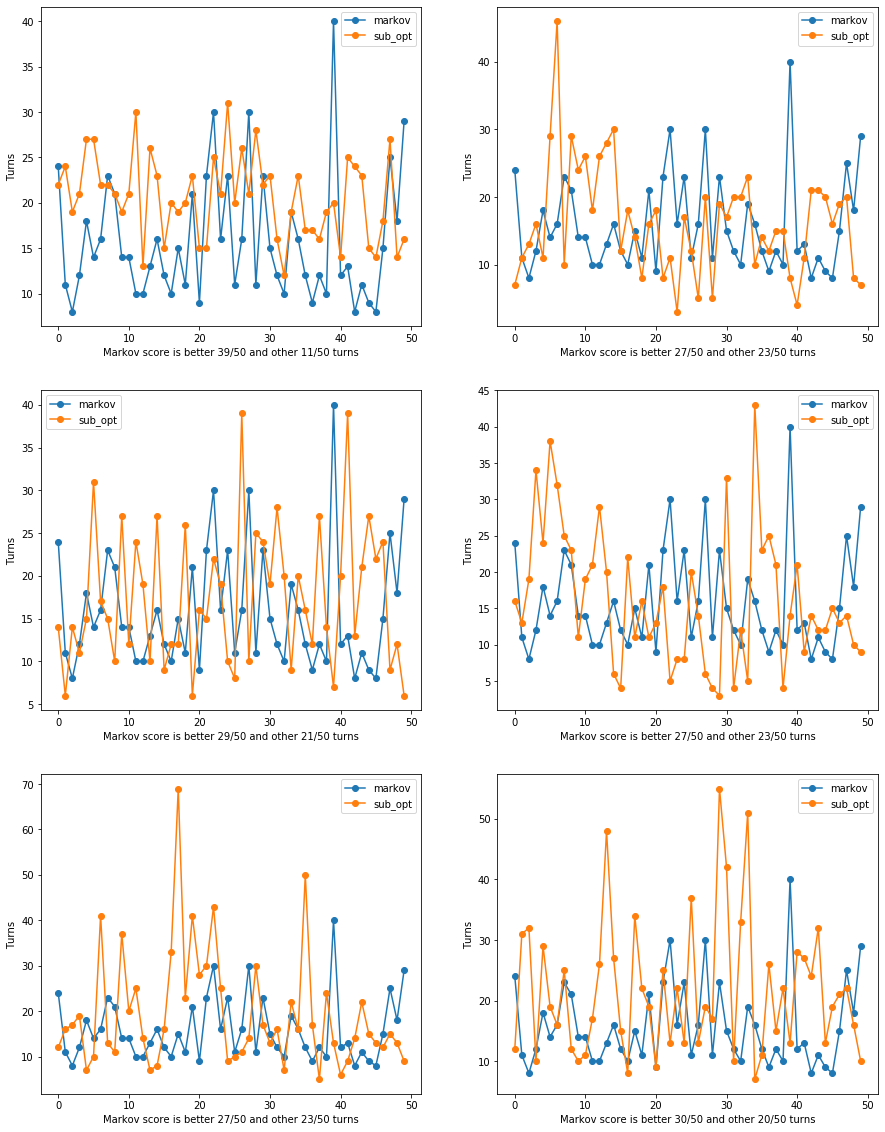

In [17]:
results = [markov_results] + total_result

make_multiple_plot(50, results, "lab", 3, 2 )
plt.savefig("fig2.png")

In [9]:
Mdp.markovDecision(layout, True)

[array([6.43705894, 5.91722528, 3.59475469, 5.99681713, 7.74522569,
        9.41840278, 9.61805556, 8.19444444, 3.61111111, 4.16666667,
        2.72569444, 2.43055556, 1.38888889, 0.83333333]),
 array([3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1])]